# Backtesting de Estratégia de Trading com CNN-LSTM para CSNA3.SA

**Objetivo:** Apresentar um backtest de uma estratégia de trading baseada em sinais de um modelo de Deep Learning (CNN-LSTM) para a ação CSNA3.SA.

**Contexto:** Este notebook demonstra o processo completo, desde a obtenção de dados até a simulação da estratégia e avaliação de performance, de forma didática. Ideal para apresentar a aplicação prática de modelos preditivos no mercado financeiro.

**Passos:**
1.  **Configuração:** Definição dos parâmetros iniciais.
2.  **Obtenção de Dados:** Download e cache de dados históricos da ação.
3.  **Engenharia de Features:** Cálculo de indicadores técnicos relevantes.
4.  **Pré-processamento:** Seleção e escalonamento das features.
5.  **Criação de Sequências:** Formatação dos dados para o modelo LSTM.
6.  **Carregamento do Modelo e Previsão:** Uso de um modelo pré-treinado para gerar probabilidades.
7.  **Simulação da Estratégia:** Execução da lógica de compra/venda baseada nas previsões.
8.  **Cálculo de Métricas:** Avaliação quantitativa da performance da estratégia.
9.  **Visualização:** Geração de gráficos para análise visual dos resultados.

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam # Using legacy Adam if needed
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import os
import time
import warnings

# Ignorar warnings futuros para uma apresentação mais limpa
warnings.simplefilter(action='ignore', category=FutureWarning)
print("Bibliotecas importadas.")

# Configuração para plots do Matplotlib no Notebook
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid') # Um estilo visualmente agradável

Bibliotecas importadas.


## 1. Configuração

Nesta seção, definimos os parâmetros essenciais para o backtest:

* `STOCK_TICKER`: O código da ação na B3 (ex: "PETR4.SA", "VALE3.SA"). **Atualmente: CSNA3.SA**
* `MODEL_FOLDER` e `MODEL_FILENAME`: Caminho para o modelo pré-treinado. O modelo deve ser específico para o ticker.
* `START_DATE` e `END_DATE`: O período para o qual faremos a simulação histórica (backtest).
* `N_STEPS`: O número de dias passados (janela) que o modelo utiliza para fazer a previsão do dia seguinte. Deve ser o mesmo valor usado no treinamento do modelo. **Atualmente: 15**
* `INITIAL_CAPITAL`: O capital inicial (em R$) para a simulação. **Atualmente: R$ 10,000.00**
* `BUY_THRESHOLD` e `SELL_THRESHOLD`: Limiares de probabilidade (gerada pelo modelo) para decidir comprar ou vender.
    * Compra se `Probabilidade > BUY_THRESHOLD`. **Atualmente: 0.50**
    * Vende se `Probabilidade < SELL_THRESHOLD` (e estiver comprado). **Atualmente: 0.50**

In [66]:
# --- 1. Configuração ---
STOCK_TICKER = "VALE3.SA" # PETR4.SA, BBAS.SA, CSNA.SA, VALE3.SA
MODEL_FOLDER = 'models'
# Garante que este nome corresponda ao modelo salvo para o ticker
MODEL_FILENAME = f"{STOCK_TICKER.replace('.', '_')}_cnn_lstm_model.keras"
MODEL_PATH = os.path.join(MODEL_FOLDER, MODEL_FILENAME)
START_DATE = "2024-01-01" # Início do período de backtest
END_DATE = pd.Timestamp.today().strftime('%Y-%m-%d') # Data de hoje (ou data final desejada)
N_STEPS = 15 # Janela usada no treinamento

# --- Parâmetros da Simulação com Limiares ---
INITIAL_CAPITAL = 10000.0 # Capital inicial em R$
BUY_THRESHOLD = 0.7      # Probabilidade mínima para comprar
SELL_THRESHOLD = 0.4     # Probabilidade máxima para manter comprado (vende abaixo disso)

print(f"--- Configuração do Backtest (Limiares de Probabilidade) ---")
print(f"Ticker: {STOCK_TICKER}")
print(f"Modelo: {MODEL_PATH}")
print(f"Período: {START_DATE} a {END_DATE}")
print(f"Capital Inicial: R$ {INITIAL_CAPITAL:,.2f}")
print(f"Limiar de Compra (Prob >): {BUY_THRESHOLD:.2f}")
print(f"Limiar de Venda (Prob <): {SELL_THRESHOLD:.2f}")
print(f"Janela de Tempo (N_STEPS): {N_STEPS}")

# Verifica se o modelo existe antes de prosseguir
if not os.path.exists(MODEL_PATH):
    print(f"\n!!! ATENÇÃO !!!")
    print(f"ERRO: Modelo não encontrado em {MODEL_PATH}")
    print(f"Verifique se o arquivo existe e se o ticker está correto.")
    # Em um notebook, podemos optar por não sair, mas alertar o usuário.
    # exit(f"ERRO: Modelo não encontrado em {MODEL_PATH}")
else:
    print(f"\nModelo encontrado em: {MODEL_PATH}")

--- Configuração do Backtest (Limiares de Probabilidade) ---
Ticker: VALE3.SA
Modelo: models/VALE3_SA_cnn_lstm_model.keras
Período: 2024-01-01 a 2025-04-27
Capital Inicial: R$ 10,000.00
Limiar de Compra (Prob >): 0.70
Limiar de Venda (Prob <): 0.40
Janela de Tempo (N_STEPS): 15

Modelo encontrado em: models/VALE3_SA_cnn_lstm_model.keras


## 2. Obtenção de Dados Históricos

Utilizamos a biblioteca `yfinance` para baixar os dados históricos da ação diretamente do Yahoo Finance.

**Funcionalidades:**
* **Buffer:** Baixamos dados de um período ligeiramente anterior (`buffer_days`) ao `START_DATE` para garantir que tenhamos dados suficientes para calcular os primeiros indicadores técnicos e sequências.
* **Caching:** Para agilizar execuções futuras e evitar downloads repetidos, salvamos os dados baixados em um arquivo CSV local (`data/{TICKER}/backtest.csv`). O script verifica se o arquivo existe e se cobre o período necessário antes de baixar novamente.
* **Seleção de Preço:** Priorizamos o uso da coluna 'Adj Close' (Preço de Fechamento Ajustado), que considera dividendos e splits, mas usamos 'Close' se 'Adj Close' não estiver disponível.

In [67]:
# --- 2. Obtenção de Dados (verificando cache local ou baixando do yfinance) ---
print("\n--- Verificando/Obtendo Dados ---")
buffer_days = 90 # Dias extras antes do start_date para cálculo de features iniciais
start_date_buffer = (pd.to_datetime(START_DATE) - pd.Timedelta(days=buffer_days)).strftime('%Y-%m-%d')

# Definir caminho do arquivo de cache
ticker_folder = os.path.join('../data', STOCK_TICKER)
cache_file = os.path.join(ticker_folder, 'backtest.csv')
download_required = False # Flag para controlar download
yf_data_full = pd.DataFrame() # Inicializa como DataFrame vazio

# Verificar se o arquivo de cache existe
if os.path.exists(cache_file):
    try:
        print(f"Carregando dados do arquivo de cache: {cache_file}")
        # Tenta carregar o cache
        yf_data_cache = pd.read_csv(cache_file, index_col=0, parse_dates=True)

        # --- NOVA LÓGICA DE VERIFICAÇÃO ---
        if not yf_data_cache.empty:
            print(f"Dados carregados do cache: {yf_data_cache.shape[0]} linhas.")
            last_cache_date = yf_data_cache.index.max()
            required_end_date_dt = pd.to_datetime(END_DATE)
            tolerance_days = 5
            min_acceptable_last_date = required_end_date_dt - pd.Timedelta(days=tolerance_days)

            # Verifica se a ÚLTIMA data no cache é recente o suficiente
            if last_cache_date >= min_acceptable_last_date:
                print(f"Cache está atualizado (Última data: {last_cache_date.strftime('%Y-%m-%d')}, Tolerância: {tolerance_days} dias). Usando cache.")
                # Filtra o cache para o período necessário (com buffer)
                yf_data_full = yf_data_cache[start_date_buffer:END_DATE].copy()
                if yf_data_full.empty:
                     print(f"Aviso: Cache cobre a data final, mas está vazio após filtrar para o período {start_date_buffer} a {END_DATE}.")
                     download_required = True # Força download se o filtro resultar em vazio
                else:
                     print(f"Dados do cache filtrados para o período {start_date_buffer} a {END_DATE}: {yf_data_full.shape[0]} linhas.")
            else:
                print(f"Cache desatualizado (Última data: {last_cache_date.strftime('%Y-%m-%d')}, Data mínima aceitável: {min_acceptable_last_date.strftime('%Y-%m-%d')}).")
                download_required = True
        else:
            print("Arquivo de cache encontrado, mas está vazio.")
            download_required = True
        # --- FIM DA NOVA LÓGICA ---

    except Exception as e:
        print(f"Erro ao carregar ou verificar arquivo de cache: {e}")
        download_required = True
else:
    print(f"Arquivo de cache não encontrado: {cache_file}")
    download_required = True

# Baixar dados se necessário
if download_required:
    try:
        print(f"Baixando dados recentes do yfinance para {STOCK_TICKER}...")
        # Usamos um end_date ligeiramente futuro para garantir que o dia atual seja incluído
        end_date_download = (pd.to_datetime(END_DATE) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        yf_data_downloaded = yf.download(STOCK_TICKER, start=start_date_buffer, end=end_date_download, progress=True)

        if yf_data_downloaded.empty:
            raise ValueError("Nenhum dado retornado pelo yfinance.")

        print(f"Dados baixados: {yf_data_downloaded.shape[0]} linhas.")
        yf_data_full_download = yf_data_downloaded.copy() # Usar uma variável diferente temporariamente

        # Remover multi-index se existir (comum em downloads de múltiplos tickers)
        if isinstance(yf_data_full_download.columns, pd.MultiIndex):
            yf_data_full_download.columns = yf_data_full_download.columns.droplevel(1) # Assume o ticker está no nível 1

        # Renomear colunas para garantir consistência (opcional, mas bom)
        yf_data_full_download = yf_data_full_download.rename(columns={
            'Open':'Open','High':'High','Low':'Low',
            'Close':'Close','Adj Close':'Adj Close','Volume':'Volume'
        })

        # Salvar dados NOVOs no arquivo de cache
        print(f"Salvando dados baixados no arquivo de cache: {cache_file}")
        os.makedirs(ticker_folder, exist_ok=True) # Garante que a pasta exista
        yf_data_full_download.to_csv(cache_file)
        print(f"Dados salvos com sucesso.")

        # Filtrar para o período exato necessário (com buffer) após download
        yf_data_full = yf_data_full_download[start_date_buffer:END_DATE].copy()
        print(f"Dados filtrados para o período {start_date_buffer} a {END_DATE}: {yf_data_full.shape[0]} linhas.")

    except Exception as e:
        print(f"ERRO CRÍTICO ao baixar ou processar dados: {e}")
        # Mantém yf_data_full como DataFrame vazio se o download falhar
        if yf_data_full.empty:
             print("Não foi possível obter dados (nem do cache, nem por download).")


# Verificar se temos dados e definir a coluna de preço
if not yf_data_full.empty:
    # Verificar colunas disponíveis e definir a coluna de preço
    if 'Adj Close' in yf_data_full.columns and not yf_data_full['Adj Close'].isnull().all():
        PRICE_COL_YF = 'Adj Close'
    elif 'Close' in yf_data_full.columns:
        PRICE_COL_YF = 'Close'
    else:
        print("ERRO: Nenhuma coluna 'Adj Close' ou 'Close' encontrada nos dados.")
        PRICE_COL_YF = None # Indicar erro

    if PRICE_COL_YF:
        print(f"Usando a coluna '{PRICE_COL_YF}' como preço base para cálculos.")
        print(f"Shape final dos dados a serem usados: {yf_data_full.shape}")
        print("Primeiras linhas dos dados:")
        print(yf_data_full.head())
        print("\nÚltimas linhas dos dados:")
        print(yf_data_full.tail())
else:
    print("ERRO: Não foi possível carregar ou baixar os dados para o período solicitado. Verifique o ticker e a conexão.")
    PRICE_COL_YF = None

# Garantir que PRICE_COL_YF exista no escopo global da célula
if 'PRICE_COL_YF' not in locals():
    PRICE_COL_YF = None


--- Verificando/Obtendo Dados ---
Arquivo de cache não encontrado: ../data/VALE3.SA/backtest.csv
Baixando dados recentes do yfinance para VALE3.SA...


[*********************100%***********************]  1 of 1 completed

Dados baixados: 388 linhas.
Salvando dados baixados no arquivo de cache: ../data/VALE3.SA/backtest.csv
Dados salvos com sucesso.
Dados filtrados para o período 2023-10-03 a 2025-04-27: 388 linhas.
Usando a coluna 'Close' como preço base para cálculos.
Shape final dos dados a serem usados: (388, 5)
Primeiras linhas dos dados:
Price           Close       High        Low       Open    Volume
Date                                                            
2023-10-03  58.650265  58.985004  58.201004  58.209815  15268800
2023-10-04  58.024830  58.826445  57.725321  58.491705  14377000
2023-10-05  58.051258  58.535749  57.839844  58.024832  11556300
2023-10-06  58.896919  59.416647  57.980783  58.042446  22711400
2023-10-09  58.474083  58.474083  57.601995  57.901504  14392200

Últimas linhas dos dados:
Price           Close       High        Low       Open    Volume
Date                                                            
2025-04-17  52.880001  53.320000  52.560001  52.779999  23172

## 3. Engenharia de Features

A engenharia de features é um passo crucial em machine learning, especialmente para séries temporais. Criamos novas variáveis (features) a partir dos dados brutos de preço e volume, que podem ajudar o modelo a identificar padrões e tendências.

**Indicadores Calculados:**
* **Retorno Diário:** Variação percentual do preço de um dia para o outro.
* **Médias Móveis Simples (SMA):** Média dos preços em janelas de 5, 10, 20 e 50 dias. Suavizam ruídos e indicam tendências.
* **Médias Móveis Exponenciais (EMA):** Semelhante à SMA, mas dá mais peso aos preços recentes (usadas para o MACD).
* **MACD (Moving Average Convergence Divergence):** Indicador de momento que mostra a relação entre duas EMAs. Inclui a linha de sinal e o histograma.
* **RSI (Relative Strength Index):** Oscilador de momento que mede a velocidade e a mudança dos movimentos de preços (escala de 0 a 100). Ajuda a identificar condições de sobrecompra/sobrevenda.
* **ROC (Rate of Change):** Mede a variação percentual do preço entre o dia atual e N dias atrás (5, 10, 20 dias).
* **Bandas de Bollinger:** Medem a volatilidade do mercado. Consistem em uma SMA (banda central) e duas bandas (superior e inferior) baseadas no desvio padrão.
* **Retornos Passados:** Calculamos o retorno percentual acumulado nos últimos 1, 3, 5, 10 e 15 dias (definido por `N_STEPS`). Isso informa o modelo sobre o desempenho recente do ativo.

**Importante:** Após calcular as features, removemos as linhas que contêm valores `NaN` (Not a Number). Isso ocorre no início do dataset, onde não há dados suficientes para calcular indicadores com janelas maiores (ex: SMA 50).

In [68]:
# --- 3. Engenharia de Features ---

def calculate_features_backtest(df, price_col='Adj Close', n_steps=15):
    '''Calcula indicadores técnicos para o backtest.'''
    df_copy = df.copy()
    if price_col not in df_copy.columns:
        raise ValueError(f"Coluna de preço '{price_col}' não encontrada no DataFrame.")

    # Retorno diário
    df_copy['daily_return'] = df_copy[price_col].pct_change() * 100

    # Médias Móveis Simples (SMA)
    for window in [5, 10, 20, 50]:
        df_copy[f'sma_{window}'] = df_copy[price_col].rolling(window=window, min_periods=1).mean()

    # Médias Móveis Exponenciais (EMA) e MACD
    df_copy['ema_12'] = df_copy[price_col].ewm(span=12, adjust=False).mean()
    df_copy['ema_26'] = df_copy[price_col].ewm(span=26, adjust=False).mean()
    df_copy['macd'] = df_copy['ema_12'] - df_copy['ema_26']
    df_copy['macd_signal'] = df_copy['macd'].ewm(span=9, adjust=False).mean()
    df_copy['macd_hist'] = df_copy['macd'] - df_copy['macd_signal']

    # RSI (Relative Strength Index)
    delta = df_copy[price_col].diff()
    gain = delta.where(delta > 0, 0).fillna(0)
    loss = -delta.where(delta < 0, 0).fillna(0)
    # Usando EWM em vez de rolling para RSI (comum e evita NaNs iniciais excessivos)
    avg_gain = gain.ewm(com=14 - 1, min_periods=14).mean() # com = span - 1 / 2 -> span = 14
    avg_loss = loss.ewm(com=14 - 1, min_periods=14).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan) # Evita divisão por zero
    df_copy['rsi'] = 100 - (100 / (1 + rs))
    df_copy['rsi'] = df_copy['rsi'].fillna(50) # Preenche NaNs iniciais com 50 (neutro)

    # ROC (Rate of Change)
    for window in [5, 10, 20]:
        df_copy[f'roc_{window}'] = df_copy[price_col].pct_change(periods=window) * 100

    # Bandas de Bollinger
    bb_window = 20
    bb_std_dev = 2
    sma_col_name = f'sma_{bb_window}'
    # Reusa SMA 20 se já calculada
    if sma_col_name not in df_copy.columns:
         middle_band_pd = df_copy[price_col].rolling(window=bb_window, min_periods=1).mean()
    else:
         middle_band_pd = df_copy[sma_col_name]
    std_dev_pd = df_copy[price_col].rolling(window=bb_window, min_periods=1).std()
    df_copy['bollinger_high'] = middle_band_pd + (bb_std_dev * std_dev_pd)
    df_copy['bollinger_low'] = middle_band_pd - (bb_std_dev * std_dev_pd)

    # Retornos passados (usando n_steps)
    # Garante que calculamos até o máximo necessário para as sequências
    for days in range(1, n_steps + 1):
        past_price = df_copy[price_col].shift(days)
        return_col_name = f'return_Past_{days}_Days_Close'
        # Usar np.where para evitar warnings com divisão por zero ou NaN
        df_copy[return_col_name] = np.where(
            past_price.notna() & (past_price != 0),
            (df_copy[price_col] / past_price - 1) * 100,
            np.nan # Mantém NaN se o preço passado for NaN ou zero
        )

    # Garante que a coluna 'Close' exista, usando o preço base se necessário
    # Isso é importante se o modelo foi treinado esperando uma feature chamada 'Close'
    if price_col == 'Adj Close' and 'Close' in df.columns:
        # Se temos Adj Close e Close original, mantemos ambos
        pass # df_copy['Close'] já existe
    elif 'Close' not in df_copy.columns:
         print(f"Coluna 'Close' não encontrada. Criando 'Close' a partir de '{price_col}'.")
         df_copy['Close'] = df_copy[price_col]
    # Se price_col já é 'Close', não faz nada

    return df_copy

if PRICE_COL_YF and not yf_data_full.empty:
    print("\n--- Calculando Features ---")
    df_backtest_features = calculate_features_backtest(yf_data_full, price_col=PRICE_COL_YF, n_steps=N_STEPS)

    print(f"Shape antes de remover NaNs: {df_backtest_features.shape}")
    initial_rows = len(df_backtest_features)
    # Remove linhas com qualquer NaN gerado pelos cálculos (especialmente no início)
    df_backtest_features.dropna(inplace=True)
    print(f"Linhas removidas por conter NaNs: {initial_rows - len(df_backtest_features)}")
    print(f"Shape final com features (após dropna): {df_backtest_features.shape}")

    if df_backtest_features.empty:
        print("ERRO: DataFrame ficou vazio após cálculo de features e remoção de NaNs.")
        # exit("ERRO: DataFrame vazio após features/dropna.")
    else:
        print("\nFeatures calculadas:")
        # Mostra as colunas geradas e uma amostra
        print(df_backtest_features.columns.tolist())
        print("\nAmostra das features:")
        print(df_backtest_features.tail()) # Tail é mais útil pois contém valores calculados
else:
    print("\n--- Pular Engenharia de Features (Dados não disponíveis) ---")
    df_backtest_features = pd.DataFrame() # Define como vazio


--- Calculando Features ---
Shape antes de remover NaNs: (388, 36)
Linhas removidas por conter NaNs: 20
Shape final com features (após dropna): (368, 36)

Features calculadas:
['Close', 'High', 'Low', 'Open', 'Volume', 'daily_return', 'sma_5', 'sma_10', 'sma_20', 'sma_50', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_hist', 'rsi', 'roc_5', 'roc_10', 'roc_20', 'bollinger_high', 'bollinger_low', 'return_Past_1_Days_Close', 'return_Past_2_Days_Close', 'return_Past_3_Days_Close', 'return_Past_4_Days_Close', 'return_Past_5_Days_Close', 'return_Past_6_Days_Close', 'return_Past_7_Days_Close', 'return_Past_8_Days_Close', 'return_Past_9_Days_Close', 'return_Past_10_Days_Close', 'return_Past_11_Days_Close', 'return_Past_12_Days_Close', 'return_Past_13_Days_Close', 'return_Past_14_Days_Close', 'return_Past_15_Days_Close']

Amostra das features:
Price           Close       High        Low       Open    Volume  \
Date                                                               
2025-04-17  5

## 4. Seleção de Features e Escalonamento

Nem todas as features calculadas são necessariamente usadas pelo modelo.

* **Seleção:** Definimos a lista `feature_cols` que contém **exatamente** as mesmas features (e na mesma ordem) usadas durante o **treinamento** do modelo CNN-LSTM. É crucial garantir essa consistência. Verificamos se todas as features esperadas estão presentes no nosso DataFrame.
* **Escalonamento:** Redes neurais geralmente funcionam melhor quando os dados de entrada estão em uma escala pequena e consistente. Utilizamos o `MinMaxScaler` do Scikit-learn para transformar todas as features selecionadas para o intervalo [0, 1]. O escalonador é ajustado (`fit`) e aplicado (`transform`) aos dados de backtest.

In [69]:
# --- 4. Seleção de Features e Escalonamento ---

# !!! IMPORTANTE: Esta lista DEVE ser idêntica à usada no TREINAMENTO do modelo !!!
# Usando a lista EXATA do seu script original que funciona.
feature_cols = [
    'daily_return', 'sma_5', 'sma_10', 'sma_20', 'sma_50', 'ema_12', 'ema_26',
    'macd', 'macd_signal', 'macd_hist', 'rsi', 'roc_5', 'roc_10', 'roc_20',
    'return_Past_1_Days_Close',  # Específico
    'return_Past_3_Days_Close',  # Específico
    'return_Past_5_Days_Close',  # Específico
    'return_Past_10_Days_Close', # Específico
    'return_Past_15_Days_Close', # Específico
    'Close', # Usar 'Close' ou 'Adj Close' consistentemente com o treino
    'bollinger_high', 'bollinger_low'
]

print("\\n--- Seleção e Escalonamento de Features ---")
# Garantir que df_backtest_features exista antes de usá-la
if 'df_backtest_features' not in locals():
     print("Aviso: Variável 'df_backtest_features' não definida. Inicializando como DataFrame vazio.")
     df_backtest_features = pd.DataFrame()

if not df_backtest_features.empty:
    # Verificar se todas as features necessárias existem
    missing_features = [col for col in feature_cols if col not in df_backtest_features.columns]
    if missing_features:
        print(f"ERRO: Features esperadas pelo modelo não encontradas no DataFrame:")
        # Mostra apenas as features que realmente estão faltando
        print([mf for mf in missing_features if mf not in df_backtest_features.columns.tolist()])
        print("\\nFeatures disponíveis:")
        print(df_backtest_features.columns.tolist())
        # Define X_backtest e X_backtest_scaled como vazios para evitar erros posteriores
        X_backtest = pd.DataFrame()
        X_backtest_scaled = np.array([])
    else:
        print(f"Selecionando {len(feature_cols)} features para o modelo:")
        # print(feature_cols) # Descomente para ver a lista final
        X_backtest = df_backtest_features[feature_cols].copy() # Seleciona as colunas

        # Escalonamento (MinMax)
        scaler_backtest = MinMaxScaler()
        # Garantir que X_backtest não está vazio antes de escalar
        if not X_backtest.empty:
            X_backtest_scaled = scaler_backtest.fit_transform(X_backtest)
            print(f"Shape dos dados selecionados: {X_backtest.shape}")
            print(f"Shape dos dados escalonados: {X_backtest_scaled.shape}")
            print("Amostra dos dados escalonados (primeiras 5 linhas):")
            print(X_backtest_scaled[:5])
        else:
             print("ERRO: DataFrame X_backtest está vazio antes do escalonamento (provavelmente devido a features ausentes).")
             X_backtest_scaled = np.array([]) # Define como vazio

else:
    print("\\n--- Pular Seleção/Escalonamento (Features não disponíveis ou df_backtest_features vazio) ---")
    X_backtest = pd.DataFrame()
    X_backtest_scaled = np.array([])

# Garantir que X_backtest_scaled exista no final da célula, mesmo se houve erro
if 'X_backtest_scaled' not in locals():
    print("Aviso: 'X_backtest_scaled' não foi criada. Definindo como array vazio.")
    X_backtest_scaled = np.array([])
# Garantir que X_backtest exista no final da célula
if 'X_backtest' not in locals():
     print("Aviso: 'X_backtest' não foi criada. Definindo como DataFrame vazio.")
     X_backtest = pd.DataFrame()

\n--- Seleção e Escalonamento de Features ---
Selecionando 22 features para o modelo:
Shape dos dados selecionados: (368, 22)
Shape dos dados escalonados: (368, 22)
Amostra dos dados escalonados (primeiras 5 linhas):
[[0.64353939 0.56897265 0.45817086 0.49557882 0.48013851 0.50883068
  0.48778841 0.52243437 0.41651921 0.88317499 0.77596747 0.93997662
  0.77066487 0.50098028 0.64353939 0.65427146 0.93997662 0.77066487
  0.61522054 0.65620433 0.51512806 0.42565238]
 [0.58591076 0.62600462 0.49308768 0.51100106 0.49592953 0.54477067
  0.50954515 0.59641592 0.4651196  0.95631211 0.81830586 0.90231996
  0.8745273  0.56713486 0.58591076 0.67060497 0.90231996 0.8745273
  0.62766157 0.69611674 0.5565505  0.40803246]
 [0.51361489 0.66399388 0.53851049 0.52720458 0.51125876 0.57769302
  0.53107014 0.65805664 0.51830339 0.99232286 0.83219521 0.7760684
  1.         0.57799091 0.51361489 0.63398163 0.7760684  1.
  0.6797288  0.70972408 0.5954913  0.39489953]
 [0.30393231 0.68236012 0.5772383  0.536

## 5. Criação de Sequências Temporais

Modelos como LSTMs (e CNNs aplicadas a séries temporais) são projetados para aprender a partir de sequências de dados, não de pontos isolados.

* **Janela Deslizante:** Transformamos nosso conjunto de dados escalonado em sequências sobrepostas. Cada sequência contém `N_STEPS` (15) dias de dados de features.
* **Formato:** O resultado (`X_backtest_seq`) é um array NumPy 3D com o formato `(numero_de_sequencias, N_STEPS, numero_de_features)`. Este é o formato esperado pela camada de entrada do modelo Keras.
* **Índices:** Também guardamos a data correspondente ao **último** dia de cada sequência (`backtest_indices`). Isso é importante para alinhar as previsões com as datas corretas no DataFrame original.

In [70]:
# --- 5. Criação de Sequências ---

def create_sequences_backtest(X_scaled, index, n_steps):
    '''Cria sequências de dados para modelos RNN/LSTM/CNN.'''
    # Verifica se X_scaled é um array numpy e tem dados suficientes
    if not isinstance(X_scaled, np.ndarray) or X_scaled.shape[0] < n_steps:
        print(f"Dados insuficientes ou formato inválido ({type(X_scaled)}, shape={X_scaled.shape if isinstance(X_scaled, np.ndarray) else 'N/A'}) para criar sequências de tamanho {n_steps}.")
        return np.array([]), np.array([]) # Retorna arrays vazios

    Xs, x_indices = [], []
    # Itera sobre os dados para criar as janelas deslizantes
    for i in range(len(X_scaled) - n_steps + 1):
        end_ix = i + n_steps
        Xs.append(X_scaled[i:end_ix])
        # Guarda o índice do ÚLTIMO dia da sequência
        x_indices.append(index[end_ix - 1])

    if not Xs: # Se a lista estiver vazia
        print("Nenhuma sequência pôde ser criada.")
        return np.array([]), np.array([])

    return np.array(Xs), np.array(x_indices)

print(f"\n--- Criação de Sequências (n_steps={N_STEPS}) ---")

# CORREÇÃO: Garante que X_backtest_scaled exista antes de ser usada.
# Se a célula anterior falhou, ela será um array vazio.
if 'X_backtest_scaled' not in locals():
    print("Aviso: Variável 'X_backtest_scaled' não definida pela célula anterior. Inicializando como vazia.")
    X_backtest_scaled = np.array([])
# Garante que X_backtest também exista para buscar o índice
if 'X_backtest' not in locals():
     print("Aviso: Variável 'X_backtest' não definida pela célula anterior. Inicializando como DataFrame vazio.")
     X_backtest = pd.DataFrame()


if X_backtest_scaled.size > 0 and not X_backtest.empty: # Verifica se temos dados escalonados E o dataframe original
    X_backtest_seq, backtest_indices = create_sequences_backtest(
        X_backtest_scaled,
        X_backtest.index, # Usa o índice do DataFrame ANTES do escalonamento
        N_STEPS
    )

    if X_backtest_seq.size == 0:
        print("ERRO: Não foi possível criar sequências. Verifique o tamanho dos dados e N_STEPS.")
        # Garante que as variáveis de saída existam mesmo em caso de erro
        backtest_dates = pd.to_datetime([])
        # Define X_backtest_seq como vazio também
        X_backtest_seq = np.array([])
    else:
        print(f"Shape das sequências de backtest (N_Sequências, N_Steps, N_Features): {X_backtest_seq.shape}")
        # backtest_indices agora contém as datas correspondentes a cada previsão
        backtest_dates = pd.to_datetime(backtest_indices)
        print(f"Número de sequências/previsões a serem feitas: {len(backtest_dates)}")
        if not backtest_dates.empty:
             print(f"Data da primeira previsão: {backtest_dates[0].date()}")
             print(f"Data da última previsão: {backtest_dates[-1].date()}")
        else:
             print("Nenhuma data de previsão disponível.")

else:
    print("\n--- Pular Criação de Sequências (Dados escalonados ou X_backtest não disponíveis) ---")
    X_backtest_seq = np.array([])
    backtest_dates = pd.to_datetime([]) # Cria um DatetimeIndex vazio

# Garantir que X_backtest_seq exista no final da célula
if 'X_backtest_seq' not in locals():
    X_backtest_seq = np.array([])
# Garantir que backtest_dates exista no final da célula
if 'backtest_dates' not in locals():
    backtest_dates = pd.to_datetime([])


--- Criação de Sequências (n_steps=15) ---
Shape das sequências de backtest (N_Sequências, N_Steps, N_Features): (354, 15, 22)
Número de sequências/previsões a serem feitas: 354
Data da primeira previsão: 2023-11-23
Data da última previsão: 2025-04-25


## 6. Carregamento do Modelo e Previsão

Agora, carregamos o modelo CNN-LSTM que foi treinado previamente e o utilizamos para gerar previsões para cada sequência de dados que criamos.

* **Carregamento:** Usamos `load_model` do Keras. A opção `compile=False` pode acelerar o carregamento quando não precisamos do estado do otimizador (comum para inferência). No entanto, o script original recompila o modelo (`model.compile(...)`), o que pode ser necessário se o modelo usar métricas customizadas ou para garantir consistência com o ambiente de treino. Mantemos a recompilação aqui.
* **Previsão:** O método `model.predict()` recebe as sequências (`X_backtest_seq`) e retorna a probabilidade de o preço da ação subir no dia seguinte (assumindo que o modelo foi treinado para classificação binária: 0=queda/manter, 1=subida). O `.flatten()` transforma a saída em um array 1D.
* **Resultados:** Armazenamos essas probabilidades em um novo DataFrame (`backtest_results_df`), usando as datas (`backtest_dates`) como índice para fácil alinhamento posterior.

In [71]:
# --- 6. Carregamento do Modelo e Previsão ---
print("\n--- Carregamento do Modelo e Previsão ---")

model = None # Inicializa a variável
# Garantir que X_backtest_seq e backtest_dates existam
if 'X_backtest_seq' not in locals(): X_backtest_seq = np.array([])
if 'backtest_dates' not in locals(): backtest_dates = pd.to_datetime([])


if X_backtest_seq.size > 0 and os.path.exists(MODEL_PATH):
    try:
        # Carrega o modelo sem recompilar inicialmente (pode ser mais rápido)
        model = load_model(MODEL_PATH, compile=False)
        print(f"Modelo {MODEL_PATH} carregado com sucesso.")

        # Recompila o modelo - necessário se usar métricas customizadas ou para garantir consistência
        # Use a taxa de aprendizado final do treinamento, se conhecida, ou um valor padrão.
        LEARNING_RATE_FINAL = 0.001 # Exemplo, ajuste se souber a LR exata do treino final
        model.compile(optimizer=LegacyAdam(learning_rate=LEARNING_RATE_FINAL),
                      loss='binary_crossentropy', # Assumindo classificação binária
                      metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]) # Exemplo de métricas
        print("Modelo recompilado com otimizador e métricas.")

        # Fazer previsões (probabilidades)
        print("Gerando previsões...")
        start_time = time.time()
        pred_probabilities = model.predict(X_backtest_seq, verbose=0).flatten() # verbose=0 para menos output
        end_time = time.time()
        print(f"Previsões geradas em {end_time - start_time:.2f} segundos.")

        # Armazenar as probabilidades com as datas corretas
        # Verifica se o número de previsões corresponde ao número de datas
        if len(pred_probabilities) == len(backtest_dates):
            backtest_results_df = pd.DataFrame({'Probability': pred_probabilities}, index=backtest_dates)
            print(f"Shape do DataFrame de resultados (probabilidades): {backtest_results_df.shape}")
            print("Amostra das probabilidades previstas:")
            print(backtest_results_df.head())
            print(backtest_results_df.tail())
        else:
             print(f"ERRO: Número de previsões ({len(pred_probabilities)}) não corresponde ao número de datas ({len(backtest_dates)}).")
             backtest_results_df = pd.DataFrame() # Define como vazio

    except Exception as e:
        print(f"ERRO ao carregar modelo ou realizar previsões: {e}")
        backtest_results_df = pd.DataFrame() # Define como vazio em caso de erro
else:
    if X_backtest_seq.size == 0:
        print("\n--- Pular Carregamento/Previsão (Sequências não disponíveis ou vazias) ---")
    if not os.path.exists(MODEL_PATH):
         print(f"\n--- Pular Carregamento/Previsão (Modelo não encontrado em {MODEL_PATH}) ---")
    backtest_results_df = pd.DataFrame() # Define como vazio

# Garantir que backtest_results_df exista
if 'backtest_results_df' not in locals():
    backtest_results_df = pd.DataFrame()


--- Carregamento do Modelo e Previsão ---
Modelo models/VALE3_SA_cnn_lstm_model.keras carregado com sucesso.
Modelo recompilado com otimizador e métricas.
Gerando previsões...


2025-04-27 10:37:15.325228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Previsões geradas em 0.44 segundos.
Shape do DataFrame de resultados (probabilidades): (354, 1)
Amostra das probabilidades previstas:
            Probability
2023-11-23     0.999987
2023-11-24     0.999896
2023-11-27     0.908904
2023-11-28     0.693715
2023-11-29     0.091821
            Probability
2025-04-17     0.006410
2025-04-22     0.652789
2025-04-23     0.993127
2025-04-24     0.999951
2025-04-25     0.999986


## 7. Simulação da Estratégia (Backtest)

Esta é a etapa central do backtest, onde simulamos a execução da estratégia de trading ao longo do período histórico definido.

**Lógica da Simulação:**
1.  **Preparação:** Combinamos os dados originais com features (`df_backtest_features`) com as probabilidades previstas (`backtest_results_df`). Adicionamos uma coluna `Trade_Price` que representa o preço de execução da ordem (assumimos o preço de abertura 'Open' do dia *seguinte* à previsão). Removemos dias sem preço de trade (geralmente o último dia).
2.  **Iteração:** Percorremos o DataFrame dia a dia.
3.  **Decisão de Trade:**
    * **Compra:** Se a probabilidade prevista para o dia (`Probability`) for **maior** que `BUY_THRESHOLD` (0.50) E não estivermos já comprados (`position_held == False`), compramos o máximo possível de ações com o caixa (`cash`) disponível, usando o `Trade_Price` (abertura do dia seguinte). O caixa vai a zero, e `position_held` vira `True`.
    * **Venda:** Se a probabilidade prevista for **menor** que `SELL_THRESHOLD` (0.50) E estivermos comprados (`position_held == True`), vendemos todas as ações (`shares`) pelo `Trade_Price`. O valor da venda volta para o caixa, as ações vão a zero, e `position_held` vira `False`.
    * **Manter:** Se nenhuma das condições acima for atendida, mantemos a posição atual (comprado ou em caixa).
4.  **Cálculo do Portfólio:** A cada dia, calculamos o valor total do portfólio (`portfolio_value`), que é a soma do caixa (`cash`) mais o valor das ações possuídas (`shares` * preço de fechamento do dia atual `current_price`).
5.  **Histórico:** Armazenamos o valor diário do portfólio em `portfolio_history`.

**Observação:** Esta é uma simulação simplificada. Não considera custos de transação (corretagem, taxas), slippage (diferença entre preço esperado e executado) ou liquidez do mercado.

In [72]:
# --- 7. Simulação da Estratégia (Limiares de Probabilidade) ---
print("\n--- Simulação da Estratégia (Backtest) ---")

# Garantir que as variáveis necessárias existam
if 'backtest_results_df' not in locals(): backtest_results_df = pd.DataFrame()
if 'df_backtest_features' not in locals(): df_backtest_features = pd.DataFrame()
if 'PRICE_COL_YF' not in locals(): PRICE_COL_YF = None

if not backtest_results_df.empty and not df_backtest_features.empty and PRICE_COL_YF:
    # Alinhar os dados de features com as datas das previsões
    # Usamos .loc para garantir o alinhamento pelo índice (datas)
    # Usamos intersection para evitar erros se os índices não se sobrepõem perfeitamente
    common_index = df_backtest_features.index.intersection(backtest_results_df.index)
    if common_index.empty:
         print("ERRO: Nenhum índice em comum entre df_backtest_features e backtest_results_df.")
         sim_data = pd.DataFrame()
    else:
        sim_data = df_backtest_features.loc[common_index].copy()
        # Juntar as probabilidades ao DataFrame de simulação
        sim_data = sim_data.join(backtest_results_df[['Probability']])

    # Continuar apenas se sim_data não estiver vazio após o join
    if not sim_data.empty:
        # Definir o preço de execução da ordem: Abertura ('Open') do dia SEGUINTE
        # Usamos shift(-1) para pegar o 'Open' do próximo dia como preço de trade
        sim_data['Trade_Price'] = sim_data['Open'].shift(-1)

        # Remover a última linha, pois não terá preço de trade (não há dia seguinte nos dados)
        # Também remove outras linhas onde 'Trade_Price' possa ser NaN por outros motivos (ex: feriados)
        initial_sim_rows = len(sim_data)
        sim_data.dropna(subset=['Trade_Price'], inplace=True)
        print(f"Linhas removidas por falta de 'Trade_Price' (geralmente a última): {initial_sim_rows - len(sim_data)}")
        print(f"Shape dos dados para simulação: {sim_data.shape}")

        if not sim_data.empty:
            # Inicialização da simulação
            cash = INITIAL_CAPITAL
            shares = 0.0
            portfolio_value = INITIAL_CAPITAL
            position_held = False # Começamos sem posição
            daily_portfolio_value = [] # Lista para guardar o valor do portfólio a cada dia
            buy_markers = [] # Guarda infos das compras (data, preço, prob)
            sell_markers = [] # Guarda infos das vendas (data, preço, prob)

            print(f"Iniciando simulação com Capital: R$ {INITIAL_CAPITAL:,.2f}")
            # Loop principal da simulação
            for date, row in sim_data.iterrows():
                # Verifica se o preço atual é válido
                if pd.isna(row[PRICE_COL_YF]):
                    # Se o preço atual for NaN, usar o último valor conhecido do portfólio
                    if daily_portfolio_value: # Se já houver valores
                        portfolio_value = daily_portfolio_value[-1]
                    else: # Se for o primeiro dia com NaN
                        portfolio_value = INITIAL_CAPITAL
                    daily_portfolio_value.append(portfolio_value)
                    continue # Pula para o próximo dia

                current_price = row[PRICE_COL_YF] # Preço do dia atual (para cálculo do valor do portfólio)
                trade_price = row['Trade_Price'] # Preço de execução (abertura do dia seguinte)
                probability_today = row['Probability'] # Probabilidade prevista para HOJE

                 # Verifica se trade_price é válido
                if pd.isna(trade_price) or trade_price <= 0:
                     # Se o preço de trade for inválido, não fazemos trade e calculamos portfólio com preço atual
                     portfolio_value = cash + (shares * current_price)
                     daily_portfolio_value.append(portfolio_value)
                     continue # Pula para o próximo dia


                # Lógica de Compra
                if probability_today > BUY_THRESHOLD and not position_held:
                    if cash > 0: # Só compra se tiver caixa
                        shares_to_buy = cash / trade_price
                        cash = 0.0 # Usa todo o caixa
                        shares = shares_to_buy
                        position_held = True
                        buy_markers.append((date, trade_price, probability_today))
                        # print(f"{date.date()}: COMPRA @ {trade_price:.2f} (Prob: {probability_today:.3f})") # Debug

                # Lógica de Venda
                elif probability_today < SELL_THRESHOLD and position_held:
                    if shares > 0: # Só vende se tiver ações
                        cash = shares * trade_price # Recebe o valor da venda
                        shares = 0.0 # Zera as ações
                        position_held = False
                        sell_markers.append((date, trade_price, probability_today))
                        # print(f"{date.date()}: VENDA @ {trade_price:.2f} (Prob: {probability_today:.3f})") # Debug

                # Cálculo do valor do portfólio no FINAL do dia atual
                portfolio_value = cash + (shares * current_price)
                daily_portfolio_value.append(portfolio_value)

            # Criar DataFrame com o histórico do portfólio
            portfolio_history = pd.DataFrame({'Portfolio_Value': daily_portfolio_value}, index=sim_data.index)
            # Calcular o retorno diário da estratégia
            portfolio_history['Daily_Return'] = portfolio_history['Portfolio_Value'].pct_change()

            print("Simulação com Limiares de Probabilidade concluída.")
            print(f"Número de compras executadas: {len(buy_markers)}")
            print(f"Número de vendas executadas: {len(sell_markers)}")
            print("Histórico do Portfólio (últimos 5 dias):")
            print(portfolio_history.tail())
        else:
            print("Não foi possível executar a simulação (DataFrame 'sim_data' está vazio após dropna).")
            portfolio_history = pd.DataFrame() # Define como vazio
    else:
         print("Não foi possível executar a simulação (DataFrame 'sim_data' está vazio após join).")
         portfolio_history = pd.DataFrame() # Define como vazio

else:
    print("\n--- Pular Simulação (Dados de previsão, features ou PRICE_COL_YF não disponíveis) ---")
    portfolio_history = pd.DataFrame() # Define como vazio

# Garantir que portfolio_history exista
if 'portfolio_history' not in locals():
    portfolio_history = pd.DataFrame()
# Garantir que buy_markers e sell_markers existam
if 'buy_markers' not in locals(): buy_markers = []
if 'sell_markers' not in locals(): sell_markers = []


--- Simulação da Estratégia (Backtest) ---
Linhas removidas por falta de 'Trade_Price' (geralmente a última): 1
Shape dos dados para simulação: (353, 38)
Iniciando simulação com Capital: R$ 10,000.00
Simulação com Limiares de Probabilidade concluída.
Número de compras executadas: 13
Número de vendas executadas: 12
Histórico do Portfólio (últimos 5 dias):
            Portfolio_Value  Daily_Return
2025-04-16      9479.080417     -0.019141
2025-04-17      9479.080417      0.000000
2025-04-22      9479.080417      0.000000
2025-04-23      9480.821002      0.000184
2025-04-24      9628.796024      0.015608


## 8. Cálculo de Métricas de Performance

Após a simulação, precisamos quantificar o desempenho da estratégia. Calculamos as seguintes métricas:

* **Valor Final do Portfólio:** O montante total (R$) ao final do período de backtest.
* **Retorno Total da Estratégia:** O lucro ou prejuízo percentual total em relação ao capital inicial. `(Valor Final / Capital Inicial) - 1`.
* **Retorno Total Buy & Hold:** O retorno percentual que teria sido obtido simplesmente comprando a ação no início do período e vendendo no final. Serve como um benchmark importante para comparar a estratégia.
* **Retorno Anualizado da Estratégia:** O retorno total convertido para uma base anual, facilitando a comparação entre estratégias com durações diferentes.
* **Retorno Anualizado do Mercado (Buy & Hold):** O retorno do benchmark anualizado.
* **Volatilidade Anualizada da Estratégia:** Uma medida do risco da estratégia, calculada como o desvio padrão dos retornos diários do portfólio, anualizado (multiplicado pela raiz quadrada do número de dias de pregão no ano, aprox. 252).
* **Sharpe Ratio (Simplificado):** Mede o retorno ajustado ao risco. Calculado aqui de forma simplificada como `Retorno Anualizado da Estratégia / Volatilidade Anualizada da Estratégia`. (Uma versão mais completa subtrairia a taxa livre de risco do retorno). Um Sharpe Ratio maior geralmente indica melhor desempenho ajustado ao risco.

**Observação:** O cálculo do Buy & Hold depende de termos os dados de preço para todo o período simulado no `df_backtest_features`.

In [73]:
# --- 8. Cálculo de Métricas (Estratégia Limiares) ---
print("\n--- Métricas de Performance (Limiares de Probabilidade) ---")

# Garantir que as variáveis existam
if 'portfolio_history' not in locals(): portfolio_history = pd.DataFrame()
if 'df_backtest_features' not in locals(): df_backtest_features = pd.DataFrame()
if 'PRICE_COL_YF' not in locals(): PRICE_COL_YF = None

# Inicializar variáveis de métricas para evitar NameError
buy_hold_return = np.nan
buy_hold_initial_price = np.nan
buy_hold_final_price = np.nan
buy_hold_data = pd.DataFrame() # Inicializa como DataFrame vazio

if not portfolio_history.empty and not df_backtest_features.empty and PRICE_COL_YF:
    final_portfolio_value = portfolio_history['Portfolio_Value'].iloc[-1]
    total_strategy_return = (final_portfolio_value / INITIAL_CAPITAL) - 1

    # Calcular Buy & Hold para o mesmo período da simulação
    start_sim_date = portfolio_history.index.min()
    end_sim_date = portfolio_history.index.max()

    # Filtrar o df_backtest_features para o período exato da simulação
    # Usar try-except para caso as datas não existam exatamente
    try:
        # Garante que o índice é do tipo DatetimeIndex
        if isinstance(df_backtest_features.index, pd.DatetimeIndex):
             buy_hold_data = df_backtest_features.loc[start_sim_date:end_sim_date, PRICE_COL_YF].copy()
             # Remover NaNs antes de calcular o retorno
             buy_hold_data.dropna(inplace=True)
             if not buy_hold_data.empty and buy_hold_data.iloc[0] != 0:
                 buy_hold_return = (buy_hold_data.iloc[-1] / buy_hold_data.iloc[0]) - 1
                 buy_hold_initial_price = buy_hold_data.iloc[0]
                 buy_hold_final_price = buy_hold_data.iloc[-1]
             else:
                 # buy_hold_return já é np.nan
                 print("Aviso: Não foi possível calcular o Buy & Hold (dados vazios, preço inicial zero ou NaNs após filtro).")
                 if not buy_hold_data.empty:
                      buy_hold_initial_price = buy_hold_data.iloc[0] # Pode ser 0 ou NaN
                      buy_hold_final_price = buy_hold_data.iloc[-1] # Pode ser NaN
        else:
             print("Aviso: Índice de df_backtest_features não é DatetimeIndex. Não é possível calcular Buy & Hold por data.")

    except KeyError:
        # buy_hold_return já é np.nan
        print("Aviso: Datas de início/fim da simulação não encontradas no DataFrame de features para Buy & Hold.")


    # Cálculos de anualização
    n_days = (end_sim_date - start_sim_date).days
    n_years = n_days / 365.25 # Aproximação de anos
    if n_years > 0:
        # Retorno total pode ser NaN se final_portfolio_value for NaN
        if not pd.isna(total_strategy_return):
             annualized_strategy_return = ((1 + total_strategy_return) ** (1/n_years)) - 1
        else:
             annualized_strategy_return = np.nan

        if not np.isnan(buy_hold_return):
            annualized_market_return = ((1 + buy_hold_return) ** (1/n_years)) - 1
        else:
            annualized_market_return = np.nan
    else: # Evita divisão por zero ou expoente infinito se o período for muito curto
        annualized_strategy_return = total_strategy_return # Retorno total se menos de um ano
        annualized_market_return = buy_hold_return

    # Volatilidade e Sharpe Ratio
    # Usamos os retornos diários do *portfólio* da estratégia
    daily_returns_strategy = portfolio_history['Daily_Return'].dropna()
    if not daily_returns_strategy.empty:
         # Verifica se há variação nos retornos para calcular std dev
         if daily_returns_strategy.nunique() > 1:
              annualized_strategy_volatility = daily_returns_strategy.std() * np.sqrt(252) # 252 dias de pregão/ano
         else:
              annualized_strategy_volatility = 0.0 # Volatilidade é zero se não houver variação
    else:
         annualized_strategy_volatility = 0.0 # Volatilidade é zero se não houver retornos

    # Sharpe Ratio (simplificado, sem taxa livre de risco)
    # Verifica se retorno e volatilidade são válidos
    if not pd.isna(annualized_strategy_return) and annualized_strategy_volatility > 0:
        sharpe_ratio = annualized_strategy_return / annualized_strategy_volatility
    else:
        sharpe_ratio = 0.0 # Ou np.nan, dependendo da preferência

    # Apresentação dos resultados
    print(f"Período Simulado: {start_sim_date.date()} a {end_sim_date.date()} ({n_days} dias)")
    print("-" * 40)
    print(f"Capital Inicial: R$ {INITIAL_CAPITAL:,.2f}")
    print(f"Valor Final Portfólio (Estratégia): R$ {final_portfolio_value:,.2f}")
    print(f"Retorno Total Estratégia: {total_strategy_return:.2%}")
    print(f"Retorno Anualizado Estratégia: {annualized_strategy_return:.2%}")
    print(f"Volatilidade Anualizada Estratégia: {annualized_strategy_volatility:.2%}")
    print(f"Sharpe Ratio (Simplificado): {sharpe_ratio:.2f}")
    print("-" * 40)
    if not np.isnan(buy_hold_return):
        final_capital_bh = INITIAL_CAPITAL * (1 + buy_hold_return)
        print(f"Valor Final Portfólio (Buy & Hold): R$ {final_capital_bh:,.2f}")
        print(f"Retorno Total Buy & Hold: {buy_hold_return:.2%}")
        print(f"Retorno Anualizado Buy & Hold: {annualized_market_return:.2%}")
        print(f"(Preço Inicial B&H: R$ {buy_hold_initial_price:.2f}, Preço Final B&H: R$ {buy_hold_final_price:.2f})")
    else:
        print("Retorno Buy & Hold: N/A")
    print("-" * 40)

else:
    print("Não foi possível calcular métricas (Histórico do portfólio, dados de features ou PRICE_COL_YF indisponíveis).")


--- Métricas de Performance (Limiares de Probabilidade) ---
Período Simulado: 2023-11-23 a 2025-04-24 (518 dias)
----------------------------------------
Capital Inicial: R$ 10,000.00
Valor Final Portfólio (Estratégia): R$ 9,628.80
Retorno Total Estratégia: -3.71%
Retorno Anualizado Estratégia: -2.63%
Volatilidade Anualizada Estratégia: 20.09%
Sharpe Ratio (Simplificado): -0.13
----------------------------------------
Valor Final Portfólio (Buy & Hold): R$ 8,441.53
Retorno Total Buy & Hold: -15.58%
Retorno Anualizado Buy & Hold: -11.26%
(Preço Inicial B&H: R$ 65.52, Preço Final B&H: R$ 55.31)
----------------------------------------


## 9. Visualização dos Resultados

Gráficos são essenciais para entender visualmente o comportamento da estratégia.

### Gráfico 1: Retorno Acumulado vs. Buy & Hold

Este gráfico compara a evolução do capital ao longo do tempo para:
* **Estratégia:** A linha roxa mostra o crescimento (ou decréscimo) do capital inicial aplicando a estratégia baseada nos limiares de probabilidade (0.5/0.5).
* **Buy & Hold:** A linha laranja tracejada representa o resultado de simplesmente comprar e segurar a ação no mesmo período.
* **Capital Inicial:** A linha cinza pontilhada representa o valor inicial (100%).
* **Sinais de Trade:**
    * Triângulos verdes (`^`) marcam os pontos na curva da *estratégia* onde uma ordem de **compra** foi executada.
    * Triângulos vermelhos (`v`) marcam os pontos na curva da *estratégia* onde uma ordem de **venda** foi executada.
* **Anotações:** Inclui os valores percentuais finais de retorno para ambas as abordagens e uma caixa de texto com os valores financeiros finais (em R$).

Este gráfico ajuda a responder: A estratégia superou o benchmark? Em que momentos ocorreram os trades?


--- Gerando Gráfico 1: Retornos Acumulados com Sinais de Trade ---


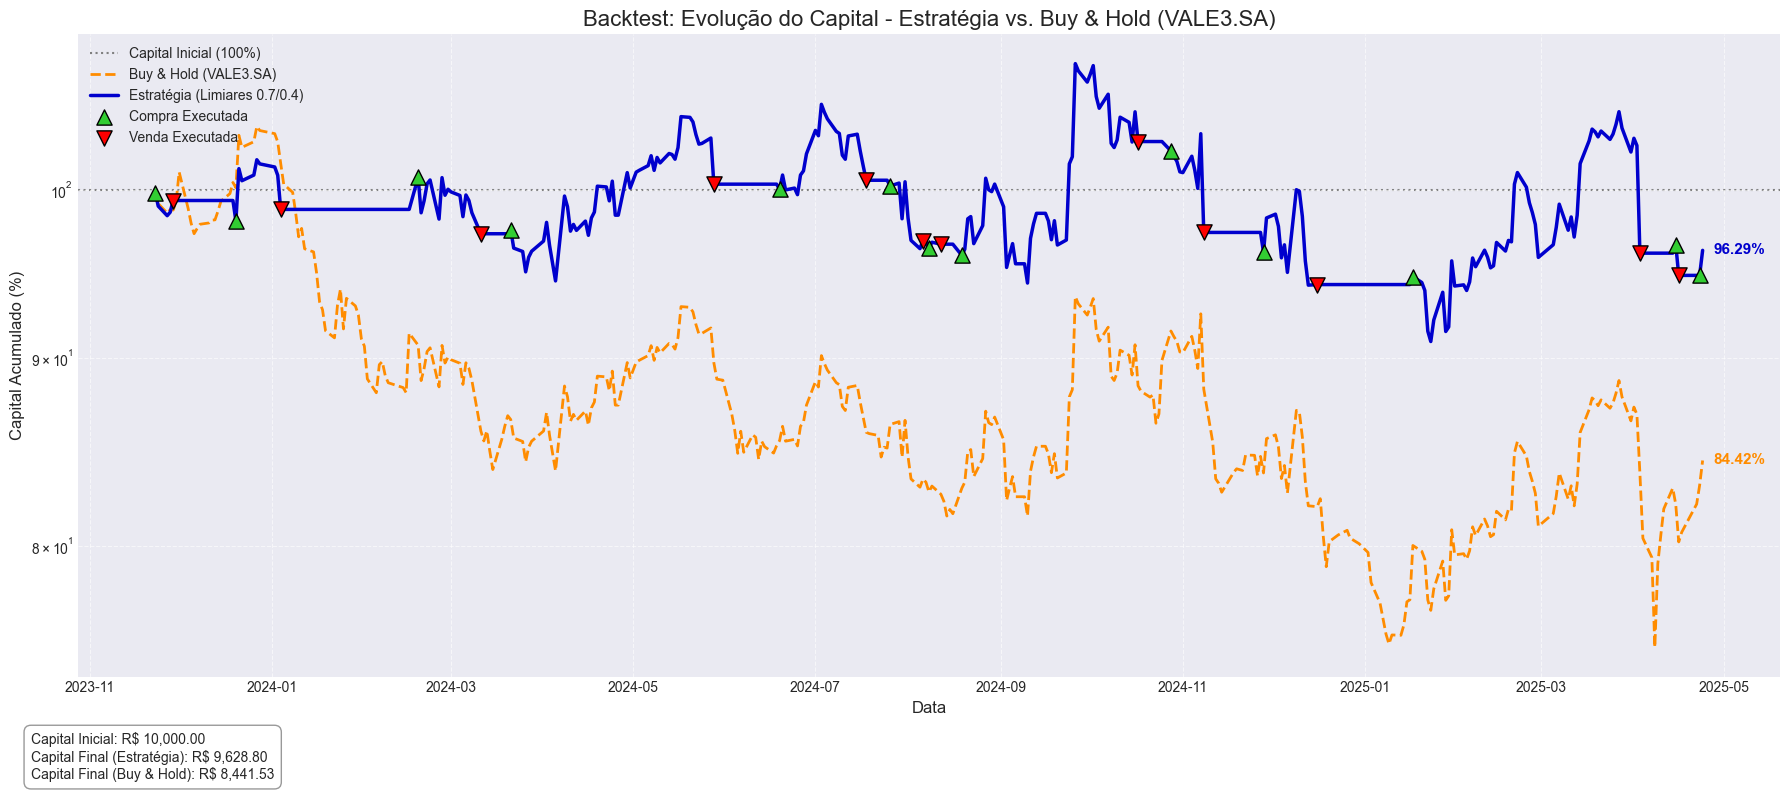

In [74]:
# --- 9. Visualização ---

# --- Gráfico 1: Retorno Acumulado com Sinais de Trade ---
print("\n--- Gerando Gráfico 1: Retornos Acumulados com Sinais de Trade ---")

# Garantir que as variáveis existam
if 'portfolio_history' not in locals(): portfolio_history = pd.DataFrame()
if 'buy_hold_data' not in locals(): buy_hold_data = pd.DataFrame()
if 'buy_markers' not in locals(): buy_markers = []
if 'sell_markers' not in locals(): sell_markers = []
if 'INITIAL_CAPITAL' not in locals(): INITIAL_CAPITAL = 0 # Evita erro se não definido
if 'BUY_THRESHOLD' not in locals(): BUY_THRESHOLD = 0.5
if 'SELL_THRESHOLD' not in locals(): SELL_THRESHOLD = 0.5
if 'STOCK_TICKER' not in locals(): STOCK_TICKER = "N/A"


# Verifica se temos dados para plotar
# Verifica se buy_hold_data foi calculado corretamente (não apenas se existe)
plot_bh = 'buy_hold_return' in locals() and not np.isnan(buy_hold_return) and not buy_hold_data.empty

if not portfolio_history.empty:

    plt.figure(figsize=(18, 8)) # Tamanho maior para melhor visualização

    # --- Plot Buy & Hold (se disponível) ---
    final_capital_bh = None # Inicializa
    if plot_bh:
        # Calcular o equity curve do Buy & Hold (base 100%)
        # Garante que o preço inicial não seja zero ou NaN
        initial_bh_price = buy_hold_data.iloc[0]
        if initial_bh_price and not pd.isna(initial_bh_price) and initial_bh_price != 0:
             buy_hold_equity = (buy_hold_data / initial_bh_price) * 100 # Começa em 100%
             plt.plot(buy_hold_equity.index, buy_hold_equity,
                      label=f'Buy & Hold ({STOCK_TICKER})', linestyle='--', linewidth=2, color='darkorange', zorder=1)

             # Anotação para o valor final do Buy & Hold
             buy_hold_final_pct = buy_hold_equity.iloc[-1]
             plt.annotate(f'{buy_hold_final_pct:.2f}%',
                           xy=(buy_hold_equity.index[-1], buy_hold_final_pct),
                           xytext=(8, 0), textcoords='offset points', # Pequeno deslocamento à direita
                           va='center', ha='left', fontsize=11, fontweight='bold',
                           color='darkorange')
             final_capital_bh = INITIAL_CAPITAL * (buy_hold_equity.iloc[-1] / 100) # Calcula valor final em R$
        else:
             print("Aviso: Preço inicial do Buy & Hold inválido para plotar equity curve.")
             plot_bh = False # Marca para não incluir na caixa de texto
    else:
        print("Aviso: Dados de Buy & Hold não disponíveis ou inválidos para plotagem.")


    # --- Plot Estratégia ---
    # Calcular o equity curve da Estratégia (base 100%)
    strategy_equity = (portfolio_history['Portfolio_Value'] / INITIAL_CAPITAL) * 100 # Começa em 100%
    plt.plot(strategy_equity.index, strategy_equity,
             label=f'Estratégia (Limiares {BUY_THRESHOLD:.1f}/{SELL_THRESHOLD:.1f})', linewidth=2.5, color='mediumblue', zorder=2) # Linha mais grossa

    # Anotação para o valor final da Estratégia
    strategy_final_pct = strategy_equity.iloc[-1]
    plt.annotate(f'{strategy_final_pct:.2f}%',
                xy=(strategy_equity.index[-1], strategy_final_pct),
                xytext=(8, 0), textcoords='offset points',
                va='center', ha='left', fontsize=11, fontweight='bold',
                color='mediumblue')
    final_capital_strategy = INITIAL_CAPITAL * (strategy_equity.iloc[-1] / 100) # Calcula valor final em R$


    # --- Marcadores de Trade (sobre a linha da ESTRATÉGIA) ---
    # Compra
    buy_dates = [m[0] for m in buy_markers]
    # Filtra para garantir que as datas existam no índice da estratégia
    valid_buy_dates = strategy_equity.index.intersection(buy_dates)
    if not valid_buy_dates.empty:
        buy_equity_points = strategy_equity.loc[valid_buy_dates]
        plt.scatter(valid_buy_dates, buy_equity_points,
                    label='Compra Executada', marker='^', color='limegreen', s=120, edgecolor='black', zorder=5)

    # Venda
    sell_dates = [m[0] for m in sell_markers]
    # Filtra para garantir que as datas existam no índice da estratégia
    valid_sell_dates = strategy_equity.index.intersection(sell_dates)
    if not valid_sell_dates.empty:
        sell_equity_points = strategy_equity.loc[valid_sell_dates]
        plt.scatter(valid_sell_dates, sell_equity_points,
                    label='Venda Executada', marker='v', color='red', s=120, edgecolor='black', zorder=5)

    # --- Formatação do Gráfico ---
    plt.axhline(100, color='grey', linestyle=':', linewidth=1.5, label='Capital Inicial (100%)', zorder=0) # Linha base
    plt.title(f'Backtest: Evolução do Capital - Estratégia vs. Buy & Hold ({STOCK_TICKER})', fontsize=16)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Capital Acumulado (%)', fontsize=12)
    plt.yscale('log') # Usar escala logarítmica pode ser útil para grandes variações

    # Adicionar caixa de texto com informações financeiras
    info_text = f"Capital Inicial: R$ {INITIAL_CAPITAL:,.2f}\n"
    info_text += f"Capital Final (Estratégia): R$ {final_capital_strategy:,.2f}\n"
    if plot_bh and final_capital_bh is not None: # Verifica se BH foi plotado e calculado
        info_text += f"Capital Final (Buy & Hold): R$ {final_capital_bh:,.2f}"
    else:
        info_text += "Capital Final (Buy & Hold): N/A"

    # Posicionar a caixa de texto no canto inferior esquerdo
    plt.figtext(0.02, 0.02, info_text, fontsize=10, fontweight='normal',
               bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, ec='gray'))

    # Ajustar legenda para não sobrepor a caixa
    handles, labels = plt.gca().get_legend_handles_labels()
    # Remover a linha base da legenda se já estiver lá para evitar duplicação
    handles = [h for h, l in zip(handles, labels) if l != 'Capital Inicial (100%)']
    labels = [l for l in labels if l != 'Capital Inicial (100%)']
    # Adicionar a linha base manualmente se necessário (garante que apareça)
    base_line = plt.Line2D([0], [0], color='grey', linestyle=':', linewidth=1.5, label='Capital Inicial (100%)')
    handles.insert(0, base_line) # Adiciona no início
    labels.insert(0, base_line.get_label())
    plt.legend(handles=handles, labels=labels, loc='upper left', fontsize=10) # Mudar local da legenda

    plt.grid(True, which='both', linestyle='--', alpha=0.6) # Grid suave para ambas as escalas (linear/log)
    plt.tight_layout(rect=[0, 0.08, 1, 1]) # Ajusta layout para dar espaço à caixa de texto (rect=[left, bottom, right, top])
    plt.show()

else:
    print("Não foi possível gerar o Gráfico 1 (Histórico do portfólio vazio).")

### Gráfico 2: Preço da Ação vs. Sinais Previstos

Este gráfico visualiza a relação entre o preço histórico da ação e os sinais gerados pelo modelo *antes* da aplicação dos limiares da estratégia.

* **Preço da Ação:** A linha azul mostra a evolução do preço de fechamento (ou ajustado) de CSNA3.SA.
* **Sinais Previstos:**
    * Triângulos verdes (`^`) indicam os dias em que a probabilidade prevista pelo modelo foi **maior que 0.5**, sugerindo uma potencial alta (sinal de "compra" do modelo).
    * Triângulos vermelhos (`v`) indicam os dias em que a probabilidade foi **menor ou igual a 0.5**, sugerindo potencial queda ou estabilidade (sinal de "venda" ou "manter" do modelo).

**Importante:** Estes são os sinais *brutos* do modelo. A estratégia simulada anteriormente pode não ter executado trades em todos esses pontos devido aos limiares (`BUY_THRESHOLD`, `SELL_THRESHOLD`) e à condição de já estar comprado/vendido.

Este gráfico ajuda a avaliar visualmente se as previsões do modelo (prob > 0.5) tendem a ocorrer antes de subidas de preço e vice-versa.


--- Gerando Gráfico 2: Preço vs Sinais Previstos (VALE3.SA) ---


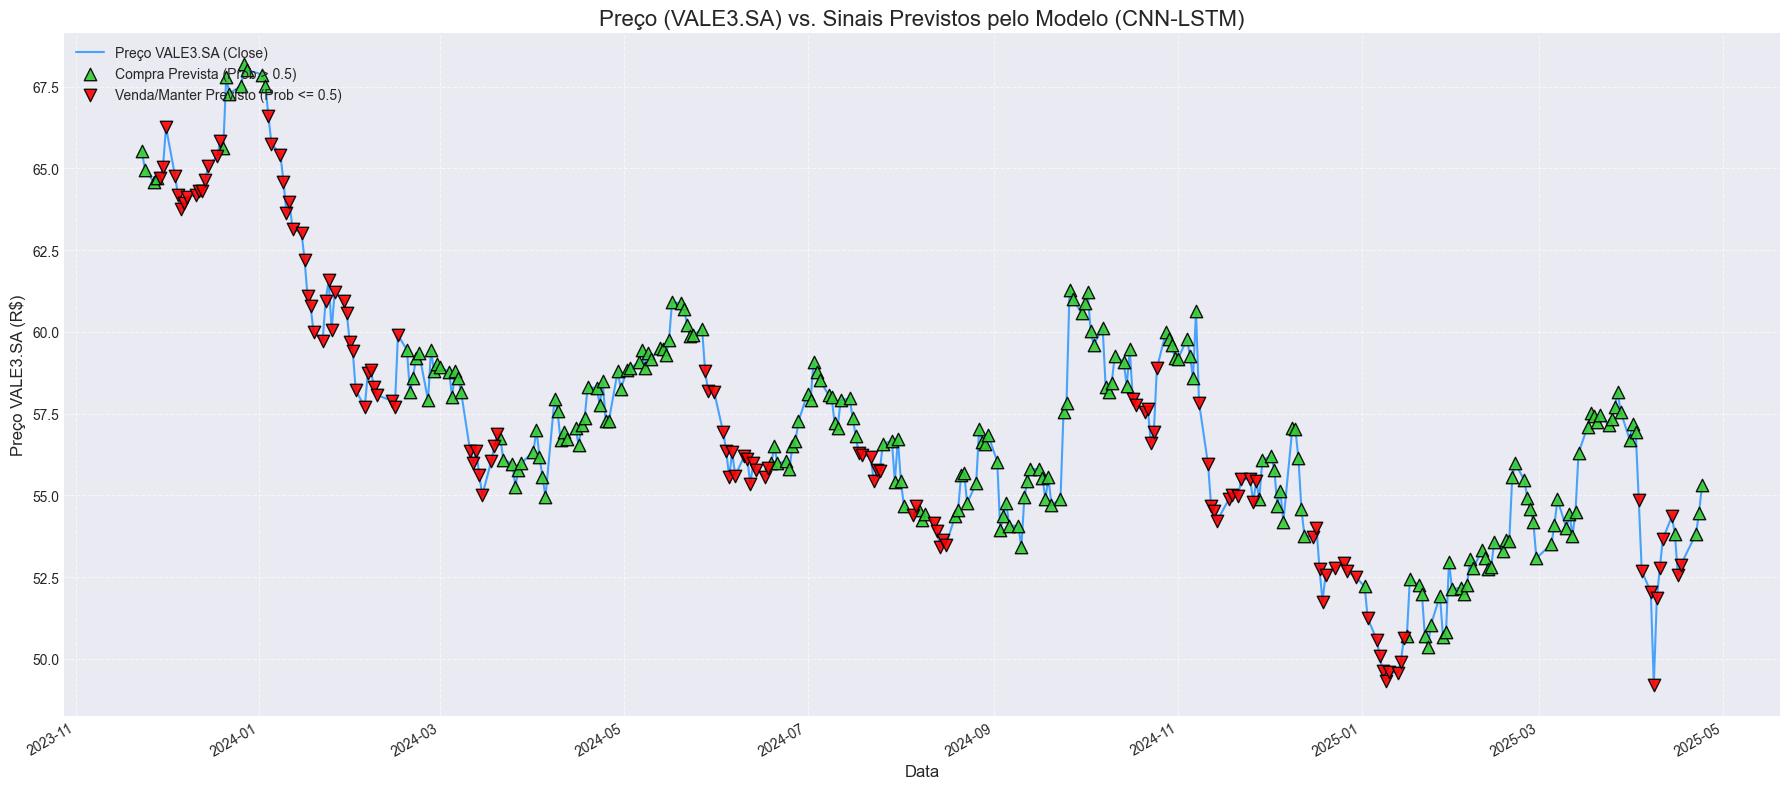


--- Script de Backtest Finalizado ---


In [75]:
# --- Gráfico 2: Preço vs. Sinais Previstos (Modelo Bruto) ---
print(f"\n--- Gerando Gráfico 2: Preço vs Sinais Previstos ({STOCK_TICKER}) ---")

# Garantir que as variáveis existam
if 'sim_data' not in locals(): sim_data = pd.DataFrame()
if 'PRICE_COL_YF' not in locals(): PRICE_COL_YF = None
if 'STOCK_TICKER' not in locals(): STOCK_TICKER = "N/A"

# Verifica se temos dados para plotar
# Usamos 'sim_data' pois ele já contém preço e probabilidade alinhados
if not sim_data.empty and PRICE_COL_YF and PRICE_COL_YF in sim_data.columns and 'Probability' in sim_data.columns:

    plt.figure(figsize=(18, 8))

    # --- Plot Preço ---
    plt.plot(sim_data.index, sim_data[PRICE_COL_YF], color='dodgerblue',
             label=f'Preço {STOCK_TICKER} ({PRICE_COL_YF})', linewidth=1.5, zorder=1, alpha=0.8)

    # --- Plot Sinais Previstos (Baseado em Prob > 0.5) ---
    # Sinal de Compra Previsto: Probabilidade > 0.5
    buy_signal_pred = sim_data[sim_data['Probability'] > 0.5]
    if not buy_signal_pred.empty:
        plt.scatter(buy_signal_pred.index, buy_signal_pred[PRICE_COL_YF],
                    label='Compra Prevista (Prob > 0.5)', marker='^',
                    color='limegreen', s=80, edgecolor='black', alpha=0.9, zorder=3)

    # Sinal de Venda/Manter Previsto: Probabilidade <= 0.5
    sell_signal_pred = sim_data[sim_data['Probability'] <= 0.5]
    if not sell_signal_pred.empty:
        plt.scatter(sell_signal_pred.index, sell_signal_pred[PRICE_COL_YF],
                    label='Venda/Manter Previsto (Prob <= 0.5)', marker='v',
                    color='red', s=80, edgecolor='black', alpha=0.9, zorder=3)

    # --- Formatação do Gráfico ---
    plt.title(f'Preço ({STOCK_TICKER}) vs. Sinais Previstos pelo Modelo (CNN-LSTM)', fontsize=16)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel(f'Preço {STOCK_TICKER} (R$)', fontsize=12)

    # Melhorar formatação do eixo X (datas)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Formato Ano-Mês
    # Ajusta a frequência dos ticks (ex: a cada 2 meses, ou auto)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) # Deixa o matplotlib escolher
    # plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Alternativa: a cada 2 meses
    plt.gcf().autofmt_xdate() # Rotaciona as datas para evitar sobreposição

    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print("Não foi possível gerar o Gráfico 2 (Dados de simulação, coluna de preço ou probabilidade indisponíveis).")

print("\n--- Script de Backtest Finalizado ---")

## 10. Conclusão e Próximos Passos

Este notebook apresentou um backtest de uma estratégia de trading utilizando um modelo CNN-LSTM pré-treinado.

**Próximos Passos Possíveis:**
* **Otimização de Parâmetros:** Testar diferentes valores para `BUY_THRESHOLD`, `SELL_THRESHOLD` e `N_STEPS`.
* **Modelos Alternativos:** Comparar o desempenho com outros modelos (ex: ARIMA, Prophet, outros modelos de DL).
* **Features Adicionais:** Incluir dados macroeconômicos, de sentimento ou de volume mais complexos.
* **Gerenciamento de Risco:** Implementar regras de stop-loss, take-profit ou alocação de capital dinâmica.
* **Custos de Transação:** Incluir estimativas de custos de corretagem e taxas para uma simulação mais realista.
* **Validação Walk-Forward:** Realizar testes fora da amostra mais robustos (out-of-sample) usando técnicas como walk-forward optimization.
* **Análise de Trades:** Investigar trades individuais (lucrativos e perdedores) para entender melhor os pontos fortes e fracos da estratégia.

Este backtest fornece uma base sólida para avaliar a viabilidade da estratégia, mas é crucial lembrar que **desempenho passado não garante resultados futuros**.